<H1>Data analysis and machine learning using custom Neural Network </H1>


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt

%matplotlib inline


<H2>Load Data</H2>

In [3]:

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_37709ff639f94158ac87880ea34e5fa2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='bRKbd0AkhpRvbRLWUFKkvNsZ1fFc6cMB2O_G1o7WEiCy',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_37709ff639f94158ac87880ea34e5fa2.get_object(Bucket='dataanalysisv2-donotdelete-pr-xbeaxc4dj5ykwg',Key='dataset_v3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


# load iris database
data = pd.read_csv(body)
data.sample(n=5)

,ID,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe),Crops
65,66,6.7,3.1,4.4,1.4,Other Kharif pulses
102,103,7.1,3.0,5.9,2.1,Rice
94,95,5.6,2.7,4.2,1.3,Other Kharif pulses
134,135,6.1,2.6,5.6,1.4,Rice
38,39,4.4,3.0,1.3,0.2,Arecanut


In [4]:
data.describe()

,ID,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


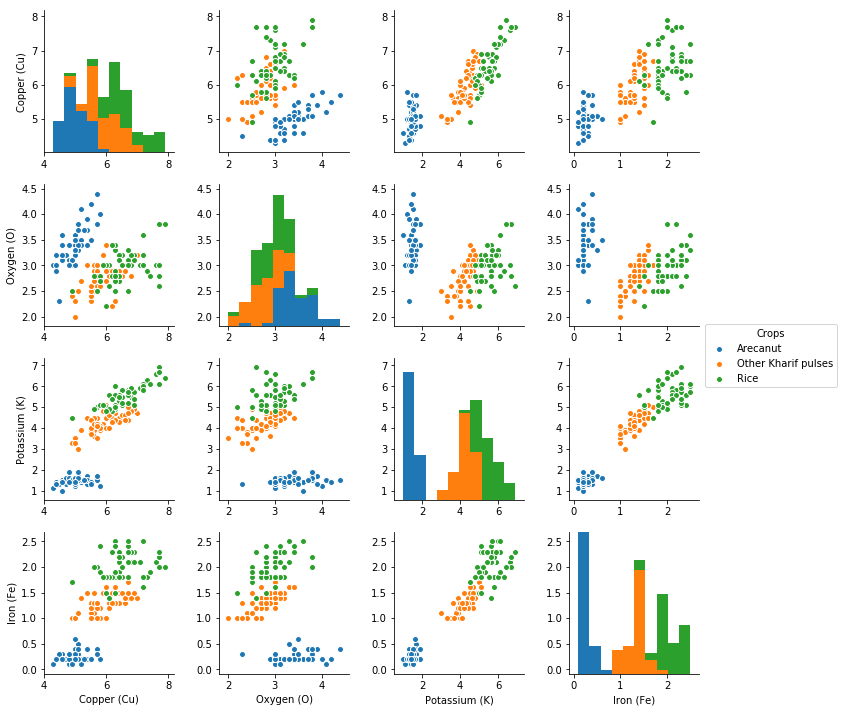

In [5]:
# simple visualization to show how the inputs compare against each other
sns.pairplot( data=data, vars=('Copper (Cu)','Oxygen (O)','Potassium (K)','Iron (Fe)'), hue='Crops' )

<H2>Normalize the data</H2>

In [6]:
df_norm = data[['Copper (Cu)','Oxygen (O)','Potassium (K)','Iron (Fe)']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_norm.sample(n=5)

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe)
24,0.138889,0.583333,0.152542,0.041667
118,0.944444,0.250000,1.000000,0.916667
29,0.111111,0.500000,0.101695,0.041667
76,0.694444,0.333333,0.644068,0.541667
107,0.833333,0.375000,0.898305,0.708333


In [7]:
df_norm.describe()

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe)
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [8]:
listCrops=list(data['Crops'].unique())
listCropCount=list(range(len(listCrops)))
target = data[['Crops']].replace(listCrops,listCropCount)
target.sample(n=5)

,Crops
137,2
130,2
1,0
123,2
96,1


In [9]:
listCrops

['Arecanut', 'Other Kharif pulses', 'Rice']

In [10]:
listCropCount

[0, 1, 2]

In [11]:
df = pd.concat([df_norm, target], axis=1)
df.sample(n=5)

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe),Crops
117,0.944444,0.750000,0.966102,0.875000,2
59,0.250000,0.291667,0.491525,0.541667,1
90,0.333333,0.250000,0.576271,0.458333,1
109,0.805556,0.666667,0.864407,1.000000,2
63,0.500000,0.375000,0.627119,0.541667,1


<H2>Mark some of the data for testing purpose.</H2>
We'll test our network on unseen data.

In [12]:
train_test_per = 90/100.0
df['train'] = np.random.rand(len(df)) < train_test_per
df.sample(n=5)

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe),Crops,train
135,0.944444,0.416667,0.864407,0.916667,2,True
19,0.222222,0.750000,0.084746,0.083333,0,True
91,0.500000,0.416667,0.610169,0.541667,1,True
13,0.000000,0.416667,0.016949,0.000000,0,True
81,0.333333,0.166667,0.457627,0.375000,1,True


<H2>Separate train and test Data</H2>

In [13]:
train = df[df.train == 1]
train = train.drop('train', axis=1).sample(frac=1)
train.sample(n=5)

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe),Crops
31,0.305556,0.583333,0.084746,0.125000,0
48,0.277778,0.708333,0.084746,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
82,0.416667,0.291667,0.491525,0.458333,1
73,0.500000,0.333333,0.627119,0.458333,1


In [14]:
test = df[df.train == 0]
test = test.drop('train', axis=1)
test.sample(n=5)

,Copper (Cu),Oxygen (O),Potassium (K),Iron (Fe),Crops
6,0.083333,0.583333,0.067797,0.083333,0
21,0.222222,0.708333,0.084746,0.125000,0
71,0.500000,0.333333,0.508475,0.500000,1
139,0.722222,0.458333,0.745763,0.833333,2
14,0.416667,0.833333,0.033898,0.041667,0


In [15]:
X = train.values[:,:4]
X[:5]

array([[ 0.25      ,  0.875     ,  0.08474576,  0.        ],
       [ 0.19444444,  0.625     ,  0.05084746,  0.08333333],
       [ 0.5       ,  0.41666667,  0.61016949,  0.54166667],
       [ 0.63888889,  0.375     ,  0.61016949,  0.5       ],
       [ 0.58333333,  0.29166667,  0.72881356,  0.75      ]])

In [ ]:
#train.values[:,4:5]

In [16]:
targets = [[1,0,0],[0,1,0],[0,0,1]]
y = np.array([targets[int(x)] for x in train.values[:,4:5]])
y[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

<H2>Create backpropagating neural network</H2>
Create 3 layers: Input, hidden and Output.

Inputs = length and widths of the species<BR>
Output = 3 values, each one indicating a species. ie Values 1, 0, 0 for the output indicates Iris-setosa<BR>
w1 is a matrices of weight connecting Input and the hidden layer. Each node in input layer connects to each node in the hidden layer.

Weight are randomized between -1 and 1.

In [17]:
num_inputs = len(X[0])
hidden_layer_neurons = 5
np.random.seed(4)
w1 = 2*np.random.random((num_inputs, hidden_layer_neurons)) - 1
w1

array([[ 0.93405968,  0.0944645 ,  0.94536872,  0.42963199,  0.39545765],
       [-0.56782101,  0.95254891, -0.98753949, -0.49403528, -0.13041694],
       [ 0.55876584, -0.60462985,  0.72598647,  0.96680135, -0.67231552],
       [ 0.19466789, -0.9820278 , -0.22685743, -0.91167988,  0.91330594]])

<H3>w2 are the weights of connections between hidden layer and output layer.</H3>

In [18]:
num_outputs = len(y[0])
w2 = 2*np.random.random((hidden_layer_neurons, num_outputs)) - 1
w2

array([[-0.12770671,  0.89795461,  0.57261197],
       [ 0.7325786 , -0.65366916, -0.85010283],
       [ 0.20148544, -0.66405563,  0.46676034],
       [-0.18311228,  0.05581765,  0.87514317],
       [ 0.04339224, -0.78361323, -0.68355319]])

<H2>Train the network by updating the weights using backpropogation.</H2>
This is the crux of the network. The layers are fed forward using sigmoid activation function. The weighs are then updated based on error using gradient descent.

<pre>
Forward Propagation ( use current weights to caluculate output ):
> node activation = output from previous layer (network inputs in case of first layer) * weights
> node output = sigmoid activation function = 1 / ( 1 + exp( node activation ) )

Backpropagation ( update network weights ):
Error calculation ( how far off we are from the expected values ):
> derivative (different for different activation functions) = output * ( 1 - output )
> error (for the last layer) = ( expected - output ) * derivative
> error (for other layers) = ( error calulated previously * that layer's weight ) * derivative
Update weight based on error caculated:
> Weight = weight + ( output * error * learning rate )
</pre>

In [19]:
# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

**A Graphical representations of our network will be something like below**<BR>
The first set of 4 nodes is the input.<BR>
The second set of 5 nodes is the hidden layer. <BR>
The last set of 3 nodes is the output layer.<BR><BR>
All the nodes of a layer are fully connected to all nodes of the next layer.

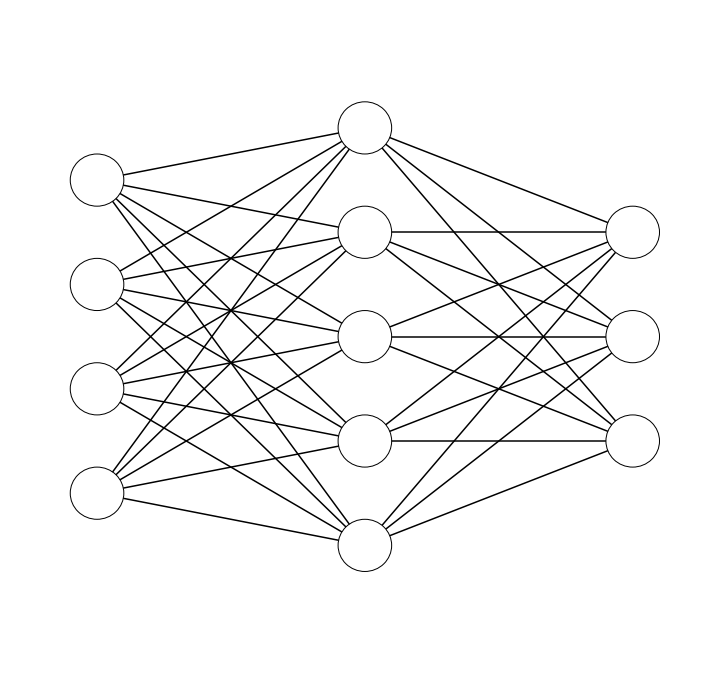

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [4, 5, 3])

The sigmoid activation function squashes the input values between 0 and 1. This provides a consistant way for the network to deal with outputs.

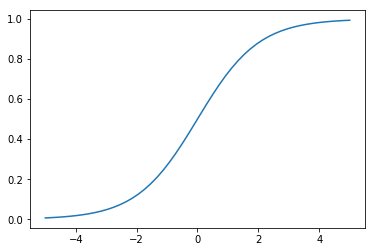

In [21]:
# sigmoid function representation
_x = np.linspace( -5, 5, 50 )
_y = 1 / ( 1 + np.exp( -_x ) )
plt.plot( _x, _y )

In [28]:
learning_rate = 2 # slowly update the network
for epoch in range(50000):
    l1 = 1/(1 + np.exp(-(np.dot(X, w1)))) # sigmoid function
    l2 = 1/(1 + np.exp(-(np.dot(l1, w2))))
    er = (abs(y - l2)).mean()
    l2_delta = (y - l2)*(l2 * (1-l2))
    l1_delta = l2_delta.dot(w2.T) * (l1 * (1-l1))
    w2 += l1.T.dot(l2_delta) * learning_rate
    w1 += X.T.dot(l1_delta) * learning_rate
print('Error:', er)


Error: 0.224358764687


<H2>Test the network for accuracy.</H2>
Run the network with the updated weights from training.

In [23]:
X = test.values[:,:4]
y = np.array([targets[int(x)] for x in test.values[:,4:5]])

l1 = 1/(1 + np.exp(-(np.dot(X, w1))))
l2 = 1/(1 + np.exp(-(np.dot(l1, w2))))

np.round(l2,3)

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

From the above maxtrix we take the maximum value (per row), which forms our predictions...

In [29]:


yp = np.argmax(l2, axis=1) # prediction
res = yp == np.argmax(y, axis=1)
correct = np.sum(res)/len(res)

testres = test[['Crops']].replace(listCropCount, listCrops)

testres['Prediction'] = yp
testres['Prediction'] = testres['Prediction'].replace(listCropCount, listCrops)

print(testres)
print('Correct:',sum(res),'/',len(res), ':', (correct*100),'%')

                   Crops           Prediction
5               Arecanut             Arecanut
6               Arecanut             Arecanut
14              Arecanut             Arecanut
21              Arecanut             Arecanut
44              Arecanut             Arecanut
54   Other Kharif pulses  Other Kharif pulses
71   Other Kharif pulses  Other Kharif pulses
92   Other Kharif pulses  Other Kharif pulses
104                 Rice  Other Kharif pulses
122                 Rice  Other Kharif pulses
137                 Rice  Other Kharif pulses
138                 Rice  Other Kharif pulses
139                 Rice  Other Kharif pulses
Correct: 8 / 13 : 61.5384615385 %


In [30]:

X = test.values[:,:4]
#X=np.array([[6.5,3.2,5.1,2.0]])
y = np.array([targets[int(x)] for x in test.values[:,4:5]])

l1 = 1/(1 + np.exp(-(np.dot(X, w1))))
l2 = 1/(1 + np.exp(-(np.dot(l1, w2))))


yp = np.argmax(l2, axis=1) # prediction
res = yp == np.argmax(y, axis=1)

print(X)

print(yp)

[[ 0.30555556  0.79166667  0.11864407  0.125     ]
 [ 0.08333333  0.58333333  0.06779661  0.08333333]
 [ 0.41666667  0.83333333  0.03389831  0.04166667]
 [ 0.22222222  0.70833333  0.08474576  0.125     ]
 [ 0.22222222  0.75        0.15254237  0.125     ]
 [ 0.61111111  0.33333333  0.61016949  0.58333333]
 [ 0.5         0.33333333  0.50847458  0.5       ]
 [ 0.41666667  0.25        0.50847458  0.45833333]
 [ 0.61111111  0.41666667  0.81355932  0.875     ]
 [ 0.94444444  0.33333333  0.96610169  0.79166667]
 [ 0.58333333  0.45833333  0.76271186  0.70833333]
 [ 0.47222222  0.41666667  0.6440678   0.70833333]
 [ 0.72222222  0.45833333  0.74576271  0.83333333]]
[0 0 0 0 0 1 1 1 1 1 1 1 1]


In [ ]:
datainput=

datainput=datainput[['Copper (Cu)','Oxygen (O)','Potassium (K)','Iron (Fe)']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

datainput[-2:]